# 1. Introduction
This dataset is a benchmark for imbalanced classification and fraud detection research. Its extreme class imbalance (0.17% fraud) makes it challenging yet realistic, requiring sophisticated techniques beyond standard machine learning approaches. Success on this dataset demonstrates capability to handle real-world fraud detection scenarios where anomalies are rare but costly.

---

## Dataset Overview

This dataset contains credit card transactions made by European cardholders in September 2013. It presents a highly imbalanced classification problem, making it an ideal case study for fraud detection methodologies.

### Key Statistics
- **Total Transactions**: 284,807
- **Fraud Cases**: 492 (0.17%)
- **Legitimate Cases**: 284,315 (99.83%)
- **Time Period**: 2 days
- **Features**: 31 (28 anonymized / PCA'd + 3 interpretable)

*Importing the libraries*

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, precision_recall_curve, 
                             average_precision_score, roc_curve, f1_score)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/compat.py:105: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


### **Importing the dataset from kaggle**

Using the kagglehub python library, I can import the data

In [160]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Path to dataset files:", path)

Path to dataset files: /Users/carlfristam/.cache/kagglehub/datasets/mlg-ulb/creditcardfraud/versions/3


In [5]:
df = pd.read_csv("creditcard.csv")

In [6]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Anonymized Features (V1-V28)
The dataset contains 28 principal components obtained through **PCA (Principal Component Analysis)** transformation. These features represent:
- Original transaction characteristics that have been transformed for confidentiality
- Already normalized and centered around zero
- Result of dimensionality reduction on the original feature space

**Why PCA?**
- Protects sensitive cardholder information
- Reduces computational complexity
- Preserves variance in the data while maintaining privacy

### Interpretable Features

#### **Time**
- Seconds elapsed between each transaction and the first transaction in the dataset
- Range: 0 to 172,792 seconds (~48 hours)
- Useful for detecting temporal patterns in fraud

#### **Amount**
- Transaction amount in Euros (€)
- Range: €0.00 to €25,691.16
- Median: ~€22
- Important for cost-sensitive learning and business impact analysis

#### **Class** (Target Variable)
- Binary classification label
- `0` = Legitimate transaction
- `1` = Fraudulent transaction

# **Basic summary**

In [4]:
df.info()
df.isnull().sum()
print(df.describe())
print(f"Fraud rate: {df['Class'].mean()*100:.4f}%")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

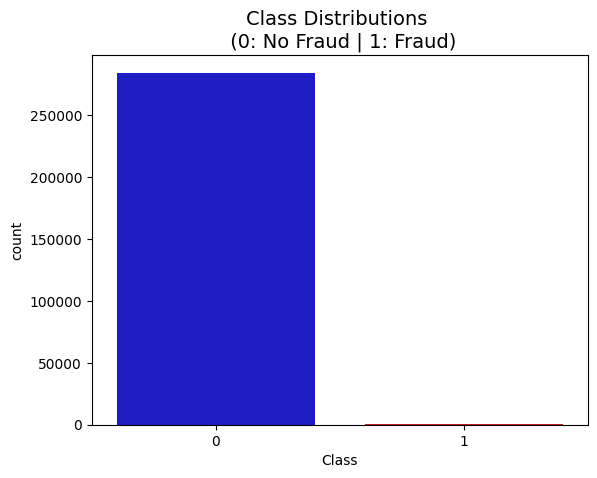

In [5]:
colors = ["#0101DF", "#DF0101"]

# New syntax (seaborn >= 0.12.0)
sns.countplot(x='Class', data=df, palette=colors)
plt.title('Class Distributions \n (0: No Fraud | 1: Fraud)', fontsize=14)
plt.show()

# **Class Imbalance Challenge**

As evident by the dataset overview shown below, as well as the plotting of the distribution of the two values in the 'Class' feature, the dataset is really imbalanced. This has to be addressed:

### The Problem
With only **0.17% fraud cases**, this is an extreme class imbalance scenario where:
- Standard accuracy is misleading (99.83% accuracy by predicting all transactions as legitimate)
- Traditional ML algorithms may fail to learn the minority class


### Why This Matters
In fraud detection:
- **False Negatives** (missed fraud) = Direct financial loss
- **False Positives** (legitimate flagged as fraud) = Customer inconvenience
- The cost of missing fraud often outweighs false alarm costs

### What does this mean for the pipeline?
- We need to approach the balancing process carefully (SMOTE, class weight parameters, etc.)
- Model evaluation requires special attention to what metrics are used (PR-AUC, Accuracy, Recall?)

# **Exploratory Data Analysis (EDA)**
We start by exploring the distribution of fraud across transaction types and over time.

# **Modularity of the code** - Pipeline set-up

For this project, the following helper functions and pipelines are defined in modules (.py files) to be used in this notebook.

___

`prepare_data()`

The prepare_data() function handles all the boring but critical setup work before any modeling happens. It lives in its own data_prep.py file so the notebook stays readable. The function scales Time and Amount, prints a quick overview of the dataset, and then performs a stratified split to make sure the fraud rate is preserved in both training and test sets. Since everything runs before any resampling, the function makes sure no data leakage creeps into the pipeline which is a key part of model-risk awareness.

`preprocess_features()`

The preprocess_features() function, stored in the same helper file, keeps feature transformations clean and consistent. It scales Time and Amount using RobustScaler and leaves the PCA components untouched. Putting it in its own file makes it easy to reuse on new data without cluttering the main notebook.

`create_pipelines()`

The create_pipelines() function, placed in pipeline.py, builds all model and resampling combinations in one place. Instead of deciding up front which model is “best,” the function sets up baseline, SMOTE, ADASYN, class weighted, and scale_pos_weight versions for each algorithm. This lets me compare how each model reacts when the data is skewed, balanced, or synthetically expanded. Having it in a dedicated file keeps the notebook clean and makes it easy to expand or remove models without rewriting anything.

`evaluate_model()`

The evaluate_model() function lives in evaluate.py and handles training, predictions, and the extraction of all metrics I need for the report. It returns ROC AUC, PR AUC, F1, and fraud-specific precision and recall which directly feed into the risk discussion later.

`compare_models()`

The compare_models() function sits in the visualization script and loops through all pipelines, runs the evaluation, logs results, and hands everything over to the plotting functions. It keeps the model comparison step consistent and makes sure every model is treated fairly.

`visualize_results()`

The visualize_results() function lives in its own helper file so the notebook stays minimal. It dynamically builds the bar charts, ROC curves, PR curves, and confusion matrices. The function adapts automatically to any number of models so I can add or remove pipelines without touching the visuals.

`run_pipeline()`

The run_pipeline() function is the main driver of the notebook. It puts all the pieces together by running the complete pipeline from data preparation to model comparison. It's a single entry point that handles all the setup, model training, and visualization. This makes it easy to run the analysis again or to modify the workflow.


In [8]:
from Helpers.data_prep import prepare_data
from Helpers.pipeline import create_pipelines, run_pipeline
from Helpers.comparison_visualization import compare_models

FRAUD DETECTION PIPELINE: SMOTE vs CLASS WEIGHTING

PREPROCESSING FEATURES
✓ Amount scaled and replaced with Amount_scaled
✓ Time scaled and replaced with Time_scaled

DATASET OVERVIEW
Dataset shape: (284807, 30)
Features: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount_scaled', 'Time_scaled']
Fraud cases: 492 (0.17%)
Non-fraud cases: 284315 (99.83%)

Training set: 199364 samples
Test set: 85443 samples
Fraud in train: 344 (0.17%)
Fraud in test: 148 (0.17%)

TRAINING AND EVALUATING MODELS

Training LR_Baseline...

LR_Baseline Results:
  ROC-AUC: 0.9529
  PR-AUC: 0.7071
  Fraud F1-Score: 0.7266
  Fraud Precision: 0.8611
  Fraud Recall: 0.6284

Training LR_SMOTE...

LR_SMOTE Results:
  ROC-AUC: 0.9655
  PR-AUC: 0.7074
  Fraud F1-Score: 0.1204
  Fraud Precision: 0.0646
  Fraud Recall: 0.8784

Training LR_ClassWeight...

LR_ClassWeight Results:

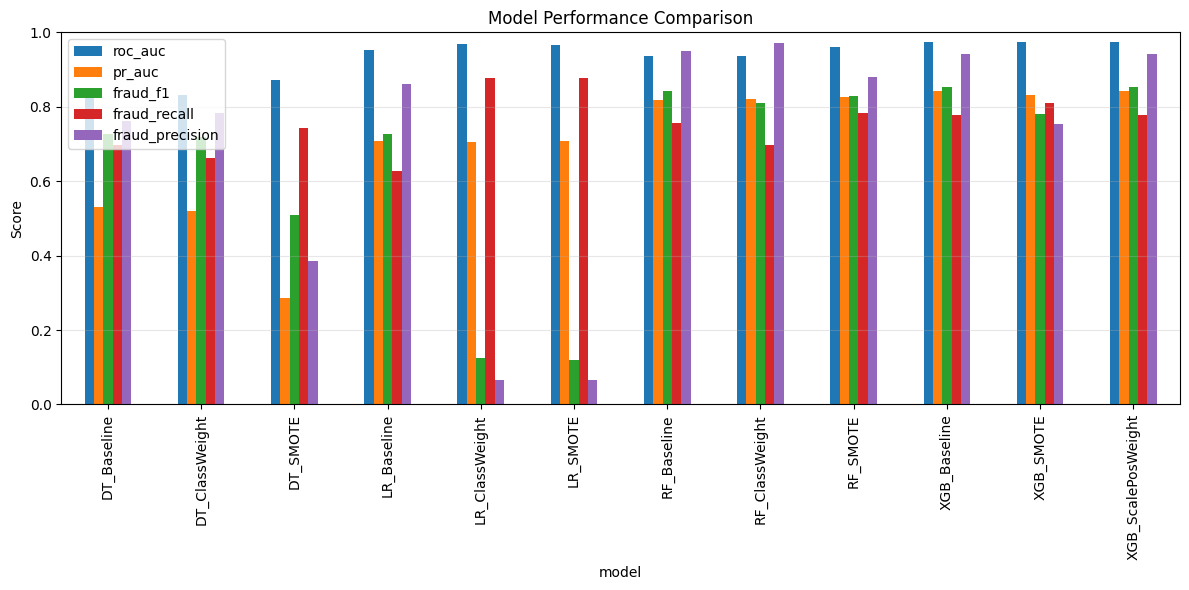

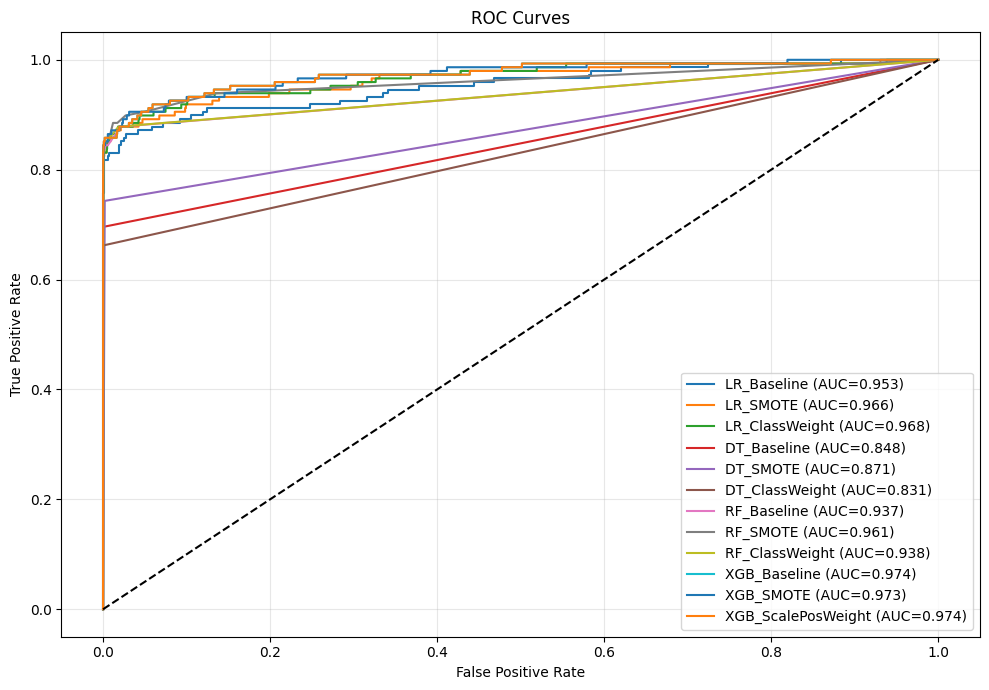

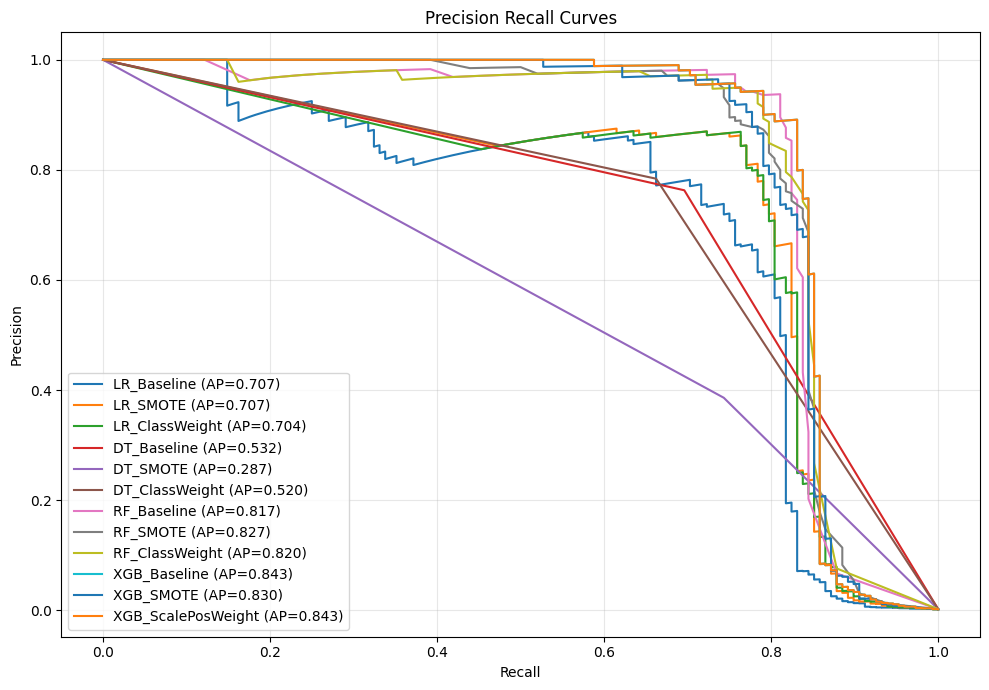

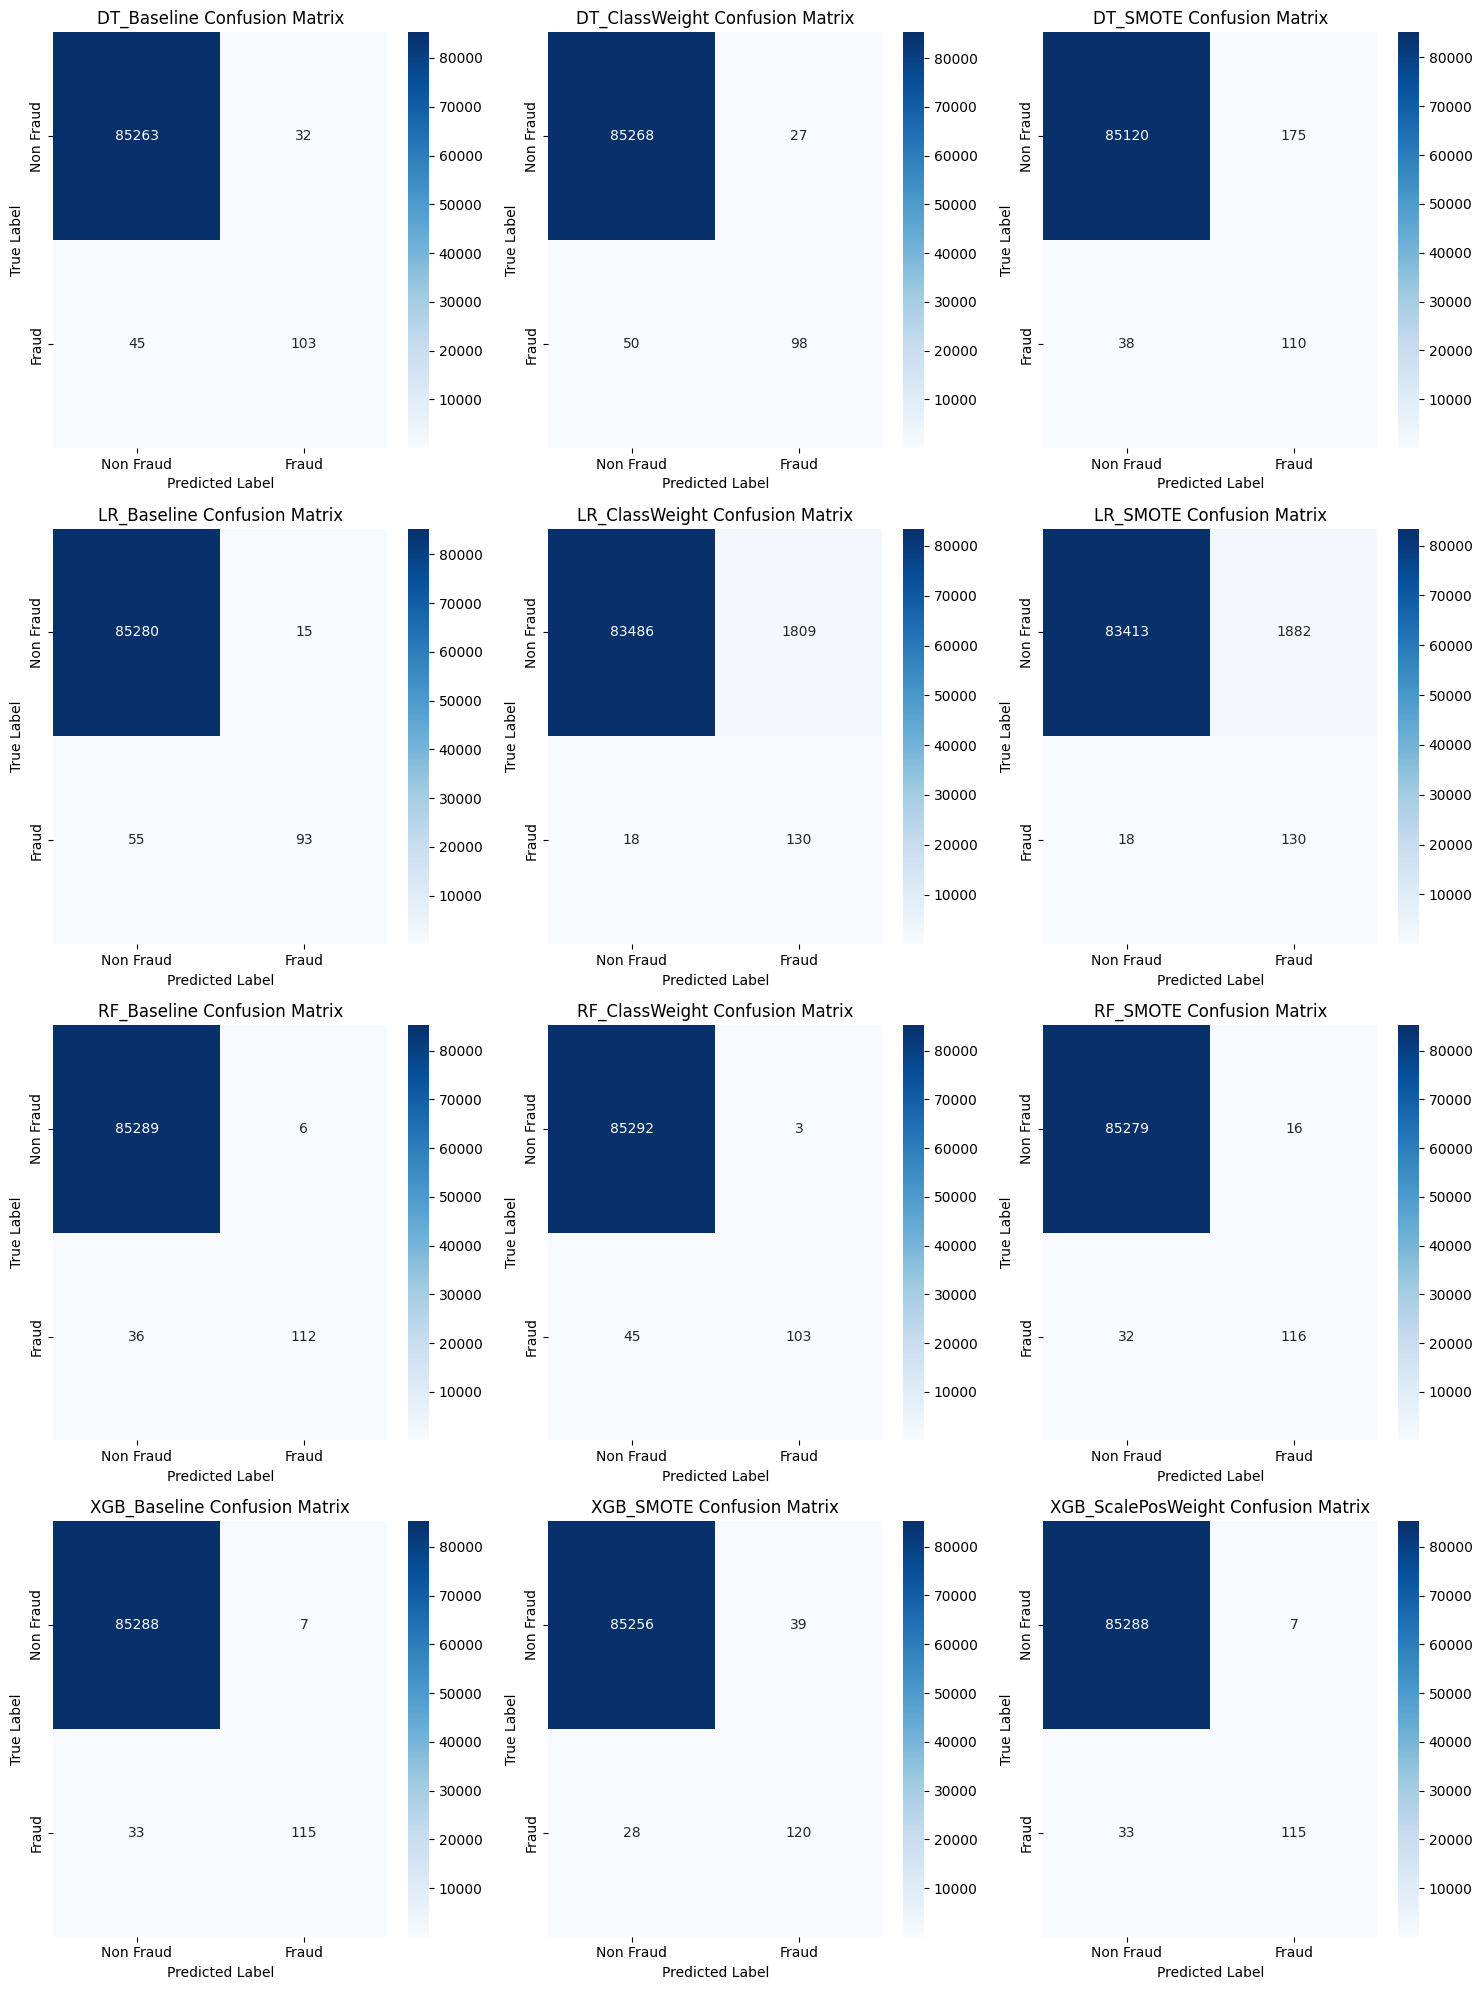


Summary Table
                 model  roc_auc  pr_auc  fraud_f1  fraud_precision  \
0          DT_Baseline   0.8478  0.5315    0.7279           0.7630   
1       DT_ClassWeight   0.8309  0.5197    0.7179           0.7840   
2             DT_SMOTE   0.8706  0.2873    0.5081           0.3860   
3          LR_Baseline   0.9529  0.7071    0.7266           0.8611   
4       LR_ClassWeight   0.9680  0.7040    0.1246           0.0670   
5             LR_SMOTE   0.9655  0.7074    0.1204           0.0646   
6          RF_Baseline   0.9374  0.8172    0.8421           0.9492   
7       RF_ClassWeight   0.9377  0.8202    0.8110           0.9717   
8             RF_SMOTE   0.9614  0.8271    0.8286           0.8788   
9         XGB_Baseline   0.9735  0.8426    0.8519           0.9426   
10           XGB_SMOTE   0.9734  0.8303    0.7818           0.7547   
11  XGB_ScalePosWeight   0.9735  0.8426    0.8519           0.9426   

    fraud_recall  
0         0.6959  
1         0.6622  
2         0.7432 

In [169]:
results, pipelines = run_pipeline(df, target_col='Class', test_size=0.3)